In [1]:
import argparse 
import sys
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import shap
from lime import lime_image
from sklearn.manifold import TSNE
from skimage.segmentation import mark_boundaries

notebook_dir = os.getcwd()
target_path = os.path.abspath(os.path.join(notebook_dir, '../Python_Code'))
sys.path.append(target_path)
from dataGenerator import DataGenerator, read_mat, DataGeneratorUnified

# Constants\n",
num_classes = 20
window_size = 50
epoch = 15

activities = {
  'A': 'Push forward',
  'C': 'Hands up and down',
  'P': 'Reading',
  'S': 'Writing'
}

model_path = '../trained_models/fine_grained_trainedon_Classroom_m1_242.h5'
test_csv = '../Data/fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv'
figures_dir = "SAIDAS/SHAP_figures"

2025-05-31 16:19:44.925843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 16:19:45.000648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 16:19:45.013687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 16:19:45.166426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-31 16:19:46.042786: W tensorflow/compiler/tf2

In [9]:
test_dir = os.path.dirname(test_csv)
NoOfSubcarrier = 242
labels = list("ABCDEFGHIJKLMNOPQRST")
test_gen = DataGenerator(test_dir, test_csv, NoOfSubcarrier, len(labels), (window_size, NoOfSubcarrier, 2), batchsize=64, shuffle=False)
print("Test gen:",len(test_gen))


Test gen: 308


In [22]:
model = load_model(model_path)

I0000 00:00:1748720104.356274 1885391 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748720104.451479 1885391 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748720104.458361 1885391 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1748720104.461744 1885391 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [10]:
print("[SHAP] Gerando explicação com SHAP...")
X_samples, _ = test_gen.__getitem__(0) # Get first batch (64 samples)
X_samplestmp1, _ =  test_gen.__getitem__(1)  # Get second batch (64 samples)

print("X_samples shape:", X_samples.shape)
print("X_samplestmp1 shape:", X_samplestmp1.shape)

[SHAP] Gerando explicação com SHAP...
X_samples shape: (64, 50, 242, 2)
X_samplestmp1 shape: (64, 50, 242, 2)


In [11]:
X_samples = np.concatenate([X_samples,X_samplestmp1],0)
print("X_samples shape after concatenation:", X_samples.shape) # 2 batches

X_samples shape after concatenation: (128, 50, 242, 2)


In [12]:
X_samplestmp2, _ =  test_gen.__getitem__(2)
X_samples = np.concatenate([X_samples,X_samplestmp2],0)
X_samplestmp3, _ =  test_gen.__getitem__(3)
X_samples = np.concatenate([X_samples,X_samplestmp3],0)
print("X_samples shape after concatenation:", X_samples.shape) # 4 batches

X_samples shape after concatenation: (256, 50, 242, 2)


In [31]:
background = X_samples[:100]  # SHAP needs a background dataset
# 100 batches is differente of 100 samples, ok?
print("Background shape:", background.shape)

Background shape: (100, 50, 242, 2)


In [35]:
X_samples[:1].shape

(1, 50, 242, 2)

In [ ]:
explainer = shap.GradientExplainer(model, background)
print("[SHAP] criou o explainer")

shap_values = explainer(X_samples[:1]) # explain only one sample
print("[SHAP] criou os valores shap")
print("Type shap_values",type(shap_values))
print("shap shap_values",shap_values.shape)

[SHAP] criou o explainer


/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 50, 242, 2))']
  warnings.warn(msg)
2025-05-31 11:30:45.735725: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1748701845.843184 1687636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748701845.872597 1687636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748701845.873366 1687636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748701845.874306 1687636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748701845.875043 1687636 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:

[SHAP] criou os valores shap
Type shap_values <class 'shap._explanation.Explanation'>
shap shap_values (1, 50, 242, 2, 20)


In [ ]:
# não entendi essa dimensões as 3 primeiras ok (1,50,242) mas não entendi o (2,20)

In [ ]:
np.savez_compressed(
  "SAIDAS/shap_output_sample1.npz",
  values=shap_values.values,
  data=shap_values.data,
  base_values=shap_values.base_values
)

# entendi que shap_values.values é o valor produzido pelo shape (1,50,242,2,20)
# e shap_values.data é o imput
# base_values está nulo... o que sera isso?
# gostei da função :-) vc testar para salvar o gradcam e embedings

In [ ]:
print("shap_values.values shape:", shap_values.values.shape)  # (1, 50, 242, 2, 20)
shap_img = shap_values[0].values[0]  # shape should be (50, 242, 2)
print("shap_img shape:", shap_img.shape)  # (

# aqui da para ver que o dimensão está diferente do esperado, ele está 
# talvez seja shap_values[0].values[:,:,:,0] no lugar de shap_values[0].values[0]

shap_values.values shape: (1, 50, 242, 2, 20)
shap_img shape: (242, 2, 20)


In [ ]:
shap_values[0].valueSs[:,:,:,0].shape  # 

(50, 242, 2)

In [66]:
# vou ter que alterar para continuar
shap_img = shap_values[0].values[:,:,:,0] # shape should be (50, 242, 2)
print("shap_img shape:", shap_img.shape) 

shap_img shape: (50, 242, 2)


In [ ]:
# Aggregate across the "channel" dimension (if needed)
shap_magnitude = np.abs(shap_img).sum(axis=-1)  # shape (50, 242)
print('shap_magnitude shape:', shap_magnitude.shape)  # (50, 242)

# agora sim

shap_magnitude shape: (50, 242)


In [71]:
# Keep only the top 5%
threshold = np.percentile(shap_magnitude, 95)  
significant_mask = shap_magnitude >= threshold

# muilto bom, não conhecia

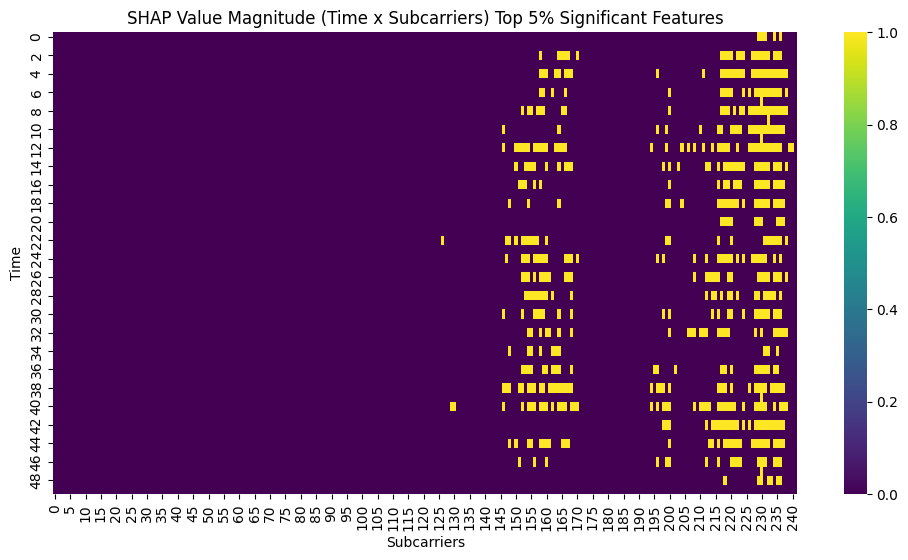

In [75]:
plt.figure(figsize=(12, 6))
sns.heatmap(significant_mask, cmap='viridis')
plt.title("SHAP Value Magnitude (Time x Subcarriers) Top 5% Significant Features")
plt.xlabel("Subcarriers")
plt.ylabel("Time")
plt.savefig(os.path.join(figures_dir, 'testeShapTop5.png'), dpi=300)
plt.show()

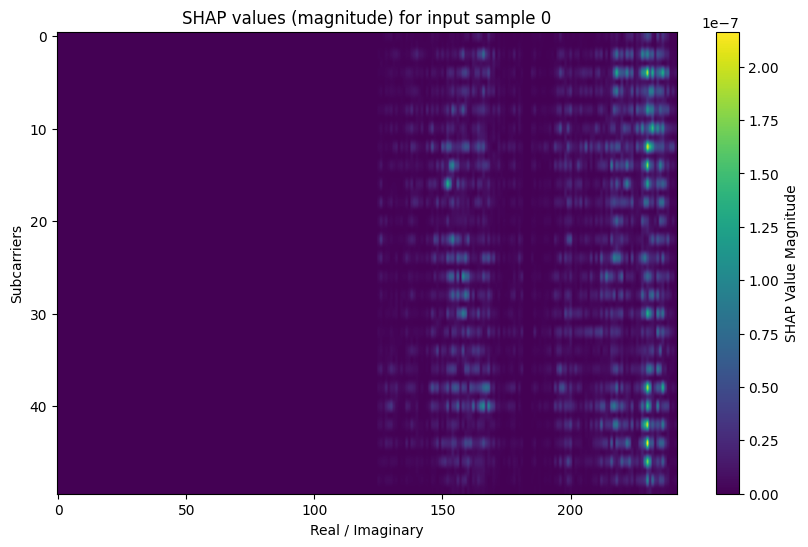

In [73]:
plt.figure(figsize=(10, 6))
plt.title("SHAP values (magnitude) for input sample 0")
plt.imshow(shap_magnitude, cmap='viridis', aspect='auto')
plt.colorbar(label='SHAP Value Magnitude')
plt.ylabel("Subcarriers")
plt.xlabel("Real / Imaginary")
plt.savefig(os.path.join(figures_dir, 'testeShap.png'), dpi=300)
plt.show()

In [4]:
print("[t-SNE] Reduzindo dimensão da penúltima camada...")
# tinha só faltado um s no input... model.inputs
penultimate_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
X_feats = penultimate_model.predict(test_gen)
tsne = TSNE(n_components=2, random_state=42)
Z = tsne.fit_transform(X_feats)
y_true = np.argmax(test_gen.labels[test_gen.indexes], axis=1)[:len(Z)]

# aconteceu um erro aqui por falta de memória na inferência... vou pegar por batches


[t-SNE] Reduzindo dimensão da penúltima camada...


/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(64, 50, 242, 2))
  warnings.warn(msg)
I0000 00:00:1748703906.642834 1722940 service.cc:146] XLA service 0x738eec0046f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748703906.642857 1722940 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-31 12:05:06.660118

  5/308 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step

I0000 00:00:1748703907.233979 1722940 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


308/308 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step


2025-05-31 12:05:32.129150: W external/local_tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.82GiB (rounded to 7327186944)requested by op ConcatV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-05-31 12:05:32.129178: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2025-05-31 12:05:32.129187: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 38, Chunks in use: 38. 9.5KiB allocated for chunks. 9.5KiB in use in bin. 5.2KiB client-requested in use in bin.
2025-05-31 12:05:32.129193: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 512B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-05-31 12:05:32.129199: I external

ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_308_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[19712,92928] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [5]:
X_feats = None
for batch_index in (range(len(test_gen))):
  X, Y = test_gen[batch_index]
  embedding = penultimate_model({'input_layer': X}, training=False) 

  if X_feats is None:
    X_feats = embedding
  else:
    X_feats = np.concatenate((X_feats, embedding), axis=0)

W0000 00:00:1748703974.306534 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.336334 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.337354 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.344555 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.345514 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.346658 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.347991 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.349020 1722622 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1748703974.350034 1722622 gp

In [13]:
y_true = test_gen.labels.to_list()

In [14]:
# estou com problema de memória, vou salvar os embeddings para recomeçar de onde parei
np.savez_compressed(
  "SAIDAS/embeddings.npz",
  X_feats=X_feats,
  y_true=y_true
)

In [29]:
# Load the saved embeddings
data = np.load("SAIDAS/embeddings.npz")
X_feats = data['X_feats']
y_true = data['y_true']

In [30]:
np.savez_compressed(
  "SAIDAS/embeddings2.npz",
  X_feats
)

In [3]:
tsne = TSNE(n_components=2, random_state=42)
Z = tsne.fit_transform(X_feats)

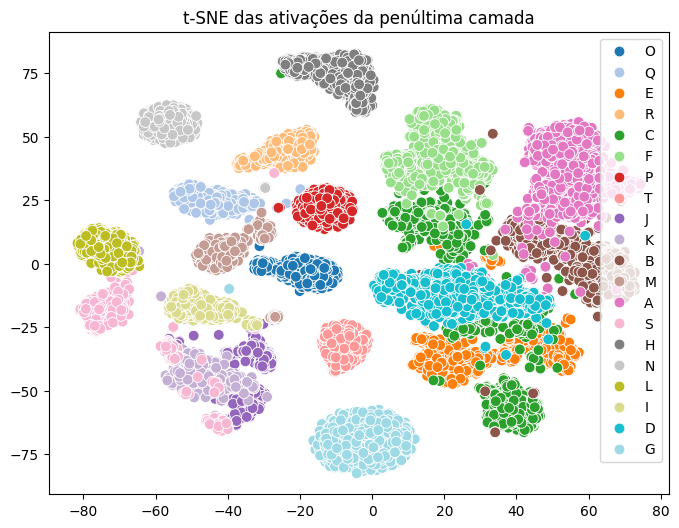

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z[:, 0], y=Z[:, 1], hue=y_true[:len(Z)], palette='tab20', s=60)
plt.title("t-SNE das ativações da penúltima camada")
plt.show()

In [14]:
X_samples[5].shape

(50, 242, 2)

In [18]:
print("[LIME] Aplicando LIME sobre uma amostra...")
sample = X_samples[5]
mag = np.sqrt(sample[:, :, 0]**2 + sample[:, :, 1]**2)
rgb_sample = np.stack([mag] * 3, axis=2)

[LIME] Aplicando LIME sobre uma amostra...


In [27]:
def predict_fn(imgs):
  print(f'1 imsg.shape: {imgs.shape}')
  imgs = np.stack([img[:, :, 0] for img in imgs])
  print(f'2 imsg.shape: {imgs.shape}')
  imgs = np.expand_dims(imgs, -1)
  print(f'3 imsg.shape: {imgs.shape}')
  imgs = np.array([np.transpose(img, (1, 0, 2)) for img in imgs])
  print(f'4 imsg.shape: {imgs.shape}')
  predictions = model.predict(imgs)
  print(f'5 predictions.shape: {predictions.shape}')
  return predictions
  # return model.predict(imgs)

In [26]:
predict_fn([rgb_sample])

AttributeError: 'list' object has no attribute 'shape'

In [28]:
lime_exp = lime_image.LimeImageExplainer()
explanation = lime_exp.explain_instance(rgb_sample.astype('double'), predict_fn, top_labels=1, num_samples=1000)
temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0], positive_only=True, hide_rest=False)

  1%|          | 9/1000 [00:00<00:05, 168.67it/s]

1 imsg.shape: (10, 50, 242, 3)
2 imsg.shape: (10, 50, 242)
3 imsg.shape: (10, 50, 242, 1)
4 imsg.shape: (10, 242, 50, 1)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 2, but received input with shape (10, 242, 50, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(10, 242, 50, 1), dtype=float32)
  • training=False
  • mask=None